In [62]:
import numpy as np
from scipy.fftpack import fft
import matplotlib.pyplot as plt
import os
# from _axion_dist import*
# from _cals import*
from joblib import Parallel, delayed
import pandas
from scipy.optimize import curve_fit, fmin
from scipy import interpolate
from scipy.stats import binned_statistic, norm
from scipy import integrate
import numpy as np
import pandas as pd
from joblib import Parallel, delayed
import math
from scipy.integrate import quad_vec
import multiprocessing as mp
import gc

In [63]:
plt.rcParams['font.size'] = 15
plt.rcParams['font.family'] = 'serif'
plt.rcParams['mathtext.fontset'] = 'dejavuserif'

### Physical constants

In [102]:
c = 299_792_458 # speed of light [m/s]
kB = 1.38064852e-23 # boltzmann constant [J/K]
h = 6.63e-34 # Plank constant [J * s]
v_rms = 270_000/c # dark matter rms velocity [m/s]
v_sun = 230_000/c # sun orbital velocity [m/s]
v_earth = 29_800/c # earth orbital velocity [m/s]
v0 = 220_000/c ### the circular rotation speed of the Galaxy at the solar radius
r_0 = v_sun / v_rms # boosting factor, median
r_max = (v_sun + v_earth) / v_rms # boosting factor, maximum
r_min = (v_sun - v_earth) / v_rms # boosting factor, minimum
Qa = 1.0e6 # axion quality factor
g0 = 1.1e-4/1e9 # axion parameter (Xe 100%) eV-1
# g0 = 6e-2/1e9 # axion parameter (Proton)
# g0 = 1.e-1/1e9 # axion parameter (Proton)
Beta = r_0*v_rms
hbar = h / (2*np.pi)
# rho_a = 3.44e-6 ## Dark matter density
rho_a = 0.45 *1e9/(1e-6) ## eV/m^3
mu0 = 4*np.pi*1e-7 ## Vacuum permiability
eV = 1.6e-19
hbarc = 197*1e6*1e-15 ## eV m

### Nuclear constants / Xe

In [103]:

f0 = 150e6
muN = 5.05e-27## Nucleion magnetic moment
muXe = 0.779*muN ## Xe nuclear magnetic moment
# mup = 1.4 * 10**-26 ##J / T ## proton magnetic moment
gamma_Xe = 11.776e6
# gamma_p = 42.577e6 ## Gyromagnetic ratio of proton
ns = 1e22 / 1e-6## number density m^3 
V = 10 * 1e-6 ## 10mL
# T2 = 1e-4 ## T2*
# Tspin = 200 ## Spin temperature
# B0 = 3.53 ## Holding field strength
# p = np.tanh(mup*B0/kB/Tspin) ## Thermal polarization rate
p = 0.05 ## Xe polarization rate
###
wa = 2*np.pi*f0
# QXe = wa * T2 / 2
QXe = 1e6 / 2 ## 2ppm 
###

In [104]:
def Qmu(Q1,Q2):
    return Q1 * Q2 / (Q1 + Q2)

### RF Chain parameters

In [105]:
Tc = 20
G = 1e8

### Conversion power & Lineshape

In [129]:
QXe0 = wa * 1000 /2
Qmu = Qa*QXe / (QXe + Qa)
Qmu0 = Qa*QXe0 / (QXe0 + Qa)

Pcon = (g0**2 *mu0*hbarc*rho_a/(wa)) * (p * muXe * ns * v_rms * c)**2 *V * Qmu
Pcon_0 = (g0**2 *mu0*hbarc*rho_a/(wa)) * (p * muXe * ns * v_rms * c)**2 *V * Qmu0 * (QXe0/QXe)
# Pcon = (g0**2 *mu0*hbarc*rho_a/(4*wa)) * (p * muXe * ns * v_rms * c)**2 *V * Qa
print('Conversion power: {:.2e} W'.format(Pcon) )
print('Conversion power ?: {:.2e} W'.format(Pcon_0) )
print('Transver magnetization: {:.2e} A/m'.format(np.sqrt(Pcon / wa * QXe / mu0 / V) ) )
print('Transver magnetization: {:.2e} A/m'.format(np.sqrt(Pcon_0 / wa * QXe / mu0 / V) ) )
###
print('F0: {:.2f} MHz'.format(f0/1e6))
print('T2:{:.2f} s,T2*:{:.2e} s'.format(QXe0*2/wa,QXe *2 / wa) )
print('T2/T2* ratio:{:.2e}, Reduced Q factor ratio (Qmu0/Qmu*): {:.2f}'.format(QXe0/QXe,Qmu0/Qmu) )
print('M0 {:.2e} A/m'.format(p*muXe *ns))
print('Volume: {:.2f} mL'.format(V*1e6) )
print('Coupling gaNN: {:.2e} eV-1'.format(g0) )
print('DM density: {:.2e} eV/m^3'.format(rho_a) )
print('DM rms velocity: {:.2e} m/s'.format(v_rms*c))
print('Rabi frequency: {:.2e} Hz'.format(0.5 * g0 *np.sqrt(2*hbarc *rho_a) * v_rms*c) )
print('Axion Q factor:{:.2e}, axion coherence time: {:.2e} s'.format(Qa,Qa/f0/np.pi) )

Conversion power: 1.34e-21 W
Conversion power ?: 3.80e-15 W
Transver magnetization: 2.38e-07 A/m
Transver magnetization: 4.01e-04 A/m
F0: 150.00 MHz
T2:1000.00 s,T2*:1.06e-03 s
T2/T2* ratio:9.42e+05, Reduced Q factor ratio (Qmu0/Qmu*): 3.00
M0 1.97e+00 A/m
Volume: 10.00 mL
Coupling gaNN: 1.10e-13 eV-1
DM density: 4.50e+14 eV/m^3
DM rms velocity: 2.70e+05 m/s
Rabi frequency: 1.98e-04 Hz
Axion Q factor:1.00e+06, axion coherence time: 2.12e-03 s


In [8]:
def La0(u, r,angle = 0):
    u = (u > 0) * u
    return ((2 / v_rms ** 2) * np.sqrt(3 / (2 * np.pi)) * 1 / r *
            np.exp(-3 / 2 * (r ** 2 + u * (2 / v_rms ** 2))) *
            np.sinh(3 * r * np.sqrt(u * (2 / v_rms ** 2))))
###
def La(u, vobs,angle = 0):
#     u = (u > 0) * u
#     return ((2 / v_rms ** 2) * np.sqrt(3 / (2 * np.pi)) * 1 / r *
#             np.exp(-3 / 2 * (r ** 2 + u * (2 / v_rms ** 2))) *
#             np.sinh(3 * r * np.sqrt(u * (2 / v_rms ** 2))))
    u = (u > 0) * u
    beta = 2*c*(vobs) / (v0*c)**2 * np.sqrt(2 * u )
    ax0 = axion_distribution1(u,vobs)
    # Calculate Da with condition for beta
    beta_safe = np.where(beta == 0, np.inf, beta)  # Replace zero beta with infinity to avoid division by zero
    tanh_term = 1 / np.tanh(beta_safe)
    tanh_term = np.where(beta == 0, 0, tanh_term)  # Set tanh_term to 0 where beta was originally zero

    Da = np.where(
        beta == 0,
        0,  # Define Da as 0 where beta is 0
        2 * c**2 / ((v0*c)**2 + vobs**2 * np.sin(angle)**2) * u * (
            np.sin(angle)**2 + (tanh_term - 1 / beta_safe) * (2 - 3 * np.sin(angle)**2) / beta_safe
        )
    )
    Da = Da *ax0
    return Da

u_peak = fmin(lambda x: -La(x, r_0* v_rms *c), 3e-7)[0]
Qs = La(u_peak, r_0 * v_rms*c)
print(Qs)

Optimization terminated successfully.
         Current function value: -799861.200234
         Iterations: 18
         Function evaluations: 36
799861.2002342856


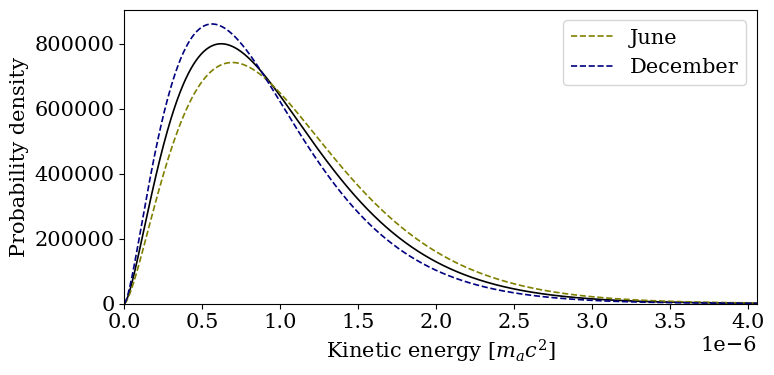

In [9]:
fig, ax = plt.subplots(figsize=(8, 4))
u = np.linspace(0, 5 * (v_rms)**2, 1001)
ax.plot(u, La(u, r_0 * v_rms*c), c='k', lw=1.2, ls='-')
# ax.plot(u, La0(u, r_0 ), c='r', lw=1.2, ls='-')
ax.plot(u, La(u, r_max* v_rms*c), c='olive', lw=1.2, ls='--', label='June')
ax.plot(u, La(u, r_min* v_rms*c), c='navy', lw=1.2, ls='--', label='December')
ax.set_xlim(left=0, right=5 * v_rms ** 2)
# ax.axhline(y = Qs,ls='--')
ax.set_ylim(bottom=0)
ax.set_xlabel('Kinetic energy [$m_{{a}}c^{{2}}$]')
ax.set_ylabel('Probability density')
ax.legend(loc=1)
fig.tight_layout(h_pad=0.0, w_pad=0.0)
plt.show()

In [10]:


def Lc(u,Qs):
    # print(Qs)
    return 1 / (1 + 4 * (Qs) ** 2 * (u - 1) ** 2)
##
def round_down_to_power_of_ten(x):
    if x == 0:
        return 0
    power = 10 ** math.floor(math.log10(x))
    return power

In [11]:
# def integrand(f, f0, f_cent,Qspin):
#     return La(f / f0 - 1,r_0* v_rms*c) * Lc(f / f_cent,Qspin)
def expected_power(f0, f_cent, RBW, Qspin, freqs):
    dfs = f_cent / Qspin
    def integrand(f):
        return La(f / f0 - 1, r_0 * v_rms * c) * Lc(f / f_cent, Qspin)
    # fmax = freqs[np.argmax(integrand(freqs))]
    # fcuts = (freqs > fmax - 4 * RBW) & (freqs < fmax + 4 * RBW)
    # freqs_c = freqs[fcuts]
    integrand_values = integrand(freqs)
    
    sorted_indices = np.argsort(integrand_values)[::-1]  
    fmax1 = freqs[sorted_indices[0]]  
    fmax2 = freqs[sorted_indices[1]]  
    
    if abs(fmax2 - fmax1) < RBW:
        fcuts = (freqs > fmax1 - 4 * RBW) & (freqs < fmax1 + 4 * RBW)
    else:
        fcuts = ((freqs > fmax1 - 4 * RBW) & (freqs < fmax1 + 4 * RBW)) | \
                ((freqs > fmax2 - 4 * RBW) & (freqs < fmax2 + 4 * RBW))
    
    freqs_c = freqs[fcuts]

    

    def integrate_func(ff):
        frange = [ff - RBW / 2, ff + RBW / 2]
        result, _ = quad_vec(integrand, frange[0], frange[1], epsabs=1e-3, epsrel=1e-3)
        return result
    ###
    # fig, ax = plt.subplots()
    # ax.plot(freqs, integrand_fast(freqs))
    # ax.axvline(x = f_cent)
    # plt.show()
    # assert 0
    ###
    results = np.array([integrate_func(ff) for ff in freqs_c])
    idx = np.argmin(np.abs(freqs - f0))
    # if idx%1000 ==0:
    #     print(np.argmin(np.abs(freqs - f0)))
        # gc.collect()
    return np.nanmax(results) / f_cent



In [12]:
f_cent = 150e6
dfa = f_cent / Qa
dfs = f_cent / QXe
dfmu = f_cent / Qmu(Qa,QXe)
RBW = round_down_to_power_of_ten(dfs / 50)
dfs_0 = round_down_to_power_of_ten(dfs )
dfa_0 = round_down_to_power_of_ten(dfa )
dfmu_0 = round_down_to_power_of_ten(dfmu)
# RBW = dfs_0
# print(dfs,dfa_0,dfs_0,dfmu_0,RBW)
n_span = 5001
# f_span = RBW * (n_span-1)
f_span = dfmu_0 * 50

n_span0 = int(f_span/dfs_0 + 1)
n_span_a = int(f_span/dfa_0 + 1)
# print(f_span,n_span0,n_span)
# f = np.linspace(f_cent - f_span / 2, f_cent + f_span / 2, n_span)
f = f_cent + np.arange(-f_span / 2, f_span / 2 + RBW, RBW)
f_0 = f_cent +  np.arange(-f_span / 2, f_span / 2 + dfs_0, dfs_0)
# print(len(f),len(f_0))

In [13]:
expected1 = np.array([expected_power(f0, f_cent, RBW, QXe, f) for f0 in f])
expected2 = np.array([ expected_power(f0,f_cent,dfs_0,QXe,f_0) for f0 in f_0 ])

In [14]:
# fig, ax = plt.subplots()
# ax.plot(f / 1e3 - f_cent/1e3,Lc(f / f_cent,QXe)  ,c='r')
# axt = ax.twinx()
# FF = 10
# axt.plot(f / 1e3 - f_cent/1e3 ,Lc(f / f_cent,QXe) * La(f / f[1300] - 1,r_0* v_rms*c),label ='Spin only',c='k')
# # axt.plot(f / 1e3 - f_cent/1e3 ,Lc(f / f_cent,QXe) * La(f / f[550] - 1,r_0* v_rms*c),label ='Spin only',c='k')
# # axt.plot(f / 1e3 - f_cent/1e3 ,Lc(f / f_cent,QXe) * La(f / f[900] - 1,r_0* v_rms*c),label ='Spin only',c='b')
# # ax.set_xlim([-0.5,0.5])
# ax.set_xlim(left = - 10 * dfs/1e3,right = 10*dfs/1e3)
# plt.show()
# ##


In [15]:
fmax= f_cent * (u_peak +1 )
df = (fmax +f_cent) / 2  - f_cent
###
expected0_1 = Lc(f / (f_cent-df) ,QXe) * Qs * RBW / f
expected0 = La(f / f_cent - 1,r_0* v_rms*c) * RBW / f
###
expected_fit = interpolate.interp1d(f / f_cent - 1,expected1 / RBW, fill_value = 'extrapolate') ## Expected fit with RBW
###
# plt.plot(f/1e3- f_cent/1e3,expected0,c = 'k')
# fig, ax = plt.subplots()
# ax.plot(f/1e3- f_cent/1e3, expected1 ,label = 'RBW = Cavity width /10')
# ax.plot((f / 1e3 - f_cent/1e3), expected0[::-1] ,c='k' ,ls = '--')
# ax.plot((f / 1e3 - f_cent/1e3), expected0_1 ,c='r' ,ls = '-.')
# # ax.plot(f_0/1e3- f_cent/1e3, expected2,label = 'RBW = Cavity width ' )
# # axt = ax.twinx()
# # axt.plot((f / 1e3 - f_cent/1e3)[::-1],La(f / f_cent - 1,r_0* v_rms*c) ,c='r',ls='--')
# # plt.plot(f/1e3,expected0,c ='k')
# # ax.set_yscale('log')
# # ax.set_xlim([-0.6,0.6])
# ax.legend(fontsize = 11)
# plt.show()

### Signal while tuning

In [16]:
QL = 1e4
Qint = 1e6/2
fa = 1e9

In [55]:
def response(rbw,Q):
    dfa = fa / Qa
    dfc = fa / Q
    F = 3
    fspan = np.max([dfa,dfc]) * 10
    f_tune = np.max([dfa,dfc]) / F
    fcs = fa + np.arange(-4*F,4*F+1) * f_tune +0e3
    # print(fcs)
    ###
    responses = {'freq': [], 'response': []}
    
    for fc in fcs:
        nspan = int(fspan // rbw)
        freqs_edge = np.linspace(fc - (nspan // 2) * rbw - rbw / 2, fc + (nspan // 2 - 0.5) * rbw, nspan + 1)
        freqs = (freqs_edge[1:] + freqs_edge[:-1]) / 2  # 중앙 주파수 계산
    
        # 주파수 컷 설정
        fcut = (freqs >= (fa - dfa)) & (freqs <= (fa + dfa * 6))
        freq_c = freqs[fcut]
    
        if len(freq_c) == 0:
            continue  # 빈 데이터는 건너뛰기
    
        def integrand(ff):
            return La(ff / fa - 1, r_0 * v_rms * c) * Lc(ff / fc, Q)
    
        def integrate_func(ff):
            frange = [ff - RBW / 2, ff + RBW / 2]
            result, _ = quad_vec(integrand, frange[0], frange[1], epsabs=1e-3, epsrel=1e-3)
            return result

        power_rbw = np.zeros_like(freqs)
        indices = np.where(fcut)[0]
        power_rbw[indices] = np.array([integrate_func(ff) for ff in freq_c]) / freq_c
    
        # 결과 저장
        responses['freq'].append(freqs)  # 전체 freqs 저장
        responses['response'].append(power_rbw)  # 크기가 맞춰진 power_rbw 저장
    return responses

In [56]:
responses_L = response(10,QL)
responses_int = response(10,Qint)
responses_H = response(10,Qint*20)

#### Low Q factor

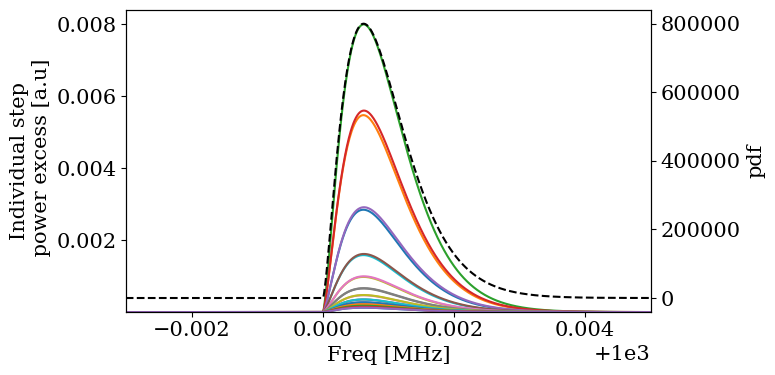

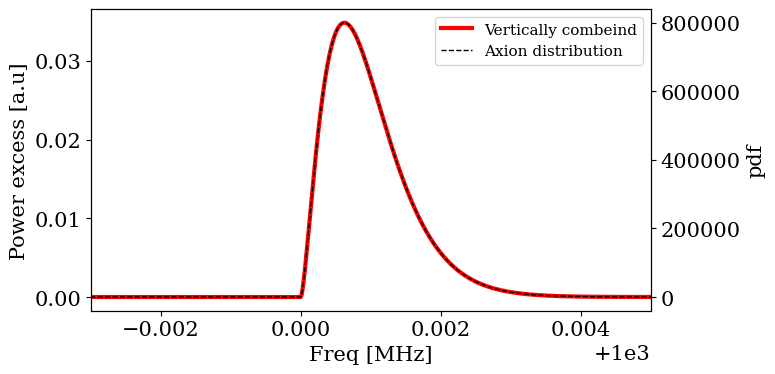

In [57]:
freqs_L = responses_L['freq']
powers_L = responses_L['response']

rbw = 10
ff = freqs_L[-1][-1]
fi = freqs_L[0][0]
n_grand = int((ff - fi ) / rbw + 1)
freq_grand = np.linspace(fi , ff , n_grand)
bin_grand = np.linspace(fi - rbw / 2, ff + rbw / 2, n_grand + 1)
sum_1, _, _ = binned_statistic(np.array(freqs_L).flatten(), np.array(powers_L).flatten() ,
                               statistic='sum', bins=bin_grand)
###
fig, ax = plt.subplots(figsize=(8, 4))
for idx,freq in enumerate(freqs_L):
    # if idx >13:
    #     continue
    ax.plot(freq/ 1e6,powers_L[idx])
    # print(len(freq))
# ax.set_yscale('log')
ax.set_ylim(bottom = 1e-5)
ax.set_xlim(left = (fa - 3*fa/Qa) / 1e6,right = (fa + 5*fa/Qa) / 1e6 )
axt = ax.twinx()
axt.plot(freq_grand/ 1e6,La(freq_grand/fa - 1,r_0* v_rms*c),c='k',ls= '--')
##
ax.set_xlabel('Freq [MHz]')
ax.set_ylabel('Individual step\n power excess [a.u]')
axt.set_ylabel('pdf')
fig.tight_layout(h_pad=0.0, w_pad=0.0)
##
plt.show()
###
fig, ax = plt.subplots(figsize=(8, 4))
ax.plot( (freq_grand) / 1e6,sum_1,c ='r',label = 'Vertically combeind',lw = '3')
ax.set_xlim(left = (fa - 3*fa/Qa) / 1e6,right = (fa + 5*fa/Qa) / 1e6 )
axt = ax.twinx()
axt.plot(freq_grand/ 1e6,La(freq_grand/fa - 1,r_0* v_rms*c),c='k',ls= '--',lw = '1',label = 'Axion distribution')

handles_ax, labels_ax = ax.get_legend_handles_labels()
handles_axt, labels_axt = axt.get_legend_handles_labels()

ax.legend(handles_ax + handles_axt, labels_ax + labels_axt, fontsize=11, loc='upper right')
ax.set_xlabel('Freq [MHz]')
ax.set_ylabel('Power excess [a.u]')
axt.set_ylabel('pdf')
fig.tight_layout(h_pad=0.0, w_pad=0.0)
plt.show()

#### Intermediate Q factor

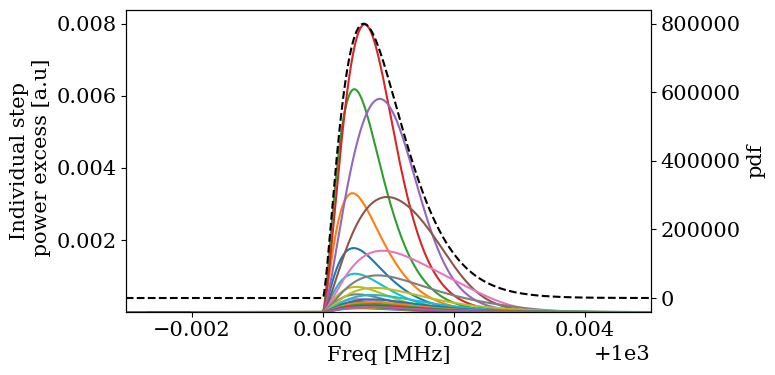

In [60]:
freqs_int = responses_int['freq']
powers_int = responses_int['response']

rbw = 10
ff = freqs_L[-1][-1]
fi = freqs_L[0][0]
n_grand = int((ff - fi ) / rbw + 1)
freq_grand = np.linspace(fi , ff , n_grand)
bin_grand = np.linspace(fi - rbw / 2, ff + rbw / 2, n_grand + 1)
sum_1, _, _ = binned_statistic(np.array(freqs_int).flatten(), np.array(powers_int).flatten() ,
                               statistic='sum', bins=bin_grand)
###
fig, ax = plt.subplots(figsize=(8, 4))
for idx,freq in enumerate(freqs_int):
    # if idx >13:
    #     continue
    ax.plot(freq/ 1e6,powers_int[idx])
    # print(len(freq))
# ax.set_yscale('log')
ax.set_ylim(bottom = 1e-5)
ax.set_xlim(left = (fa - 3*fa/Qa) / 1e6,right = (fa + 5*fa/Qa) / 1e6 )
axt = ax.twinx()
axt.plot(freq_grand/ 1e6,La(freq_grand/fa - 1,r_0* v_rms*c),c='k',ls= '--')
##
ax.set_xlabel('Freq [MHz]')
ax.set_ylabel('Individual step\n power excess [a.u]')
axt.set_ylabel('pdf')
fig.tight_layout(h_pad=0.0, w_pad=0.0)
##
plt.show()
###


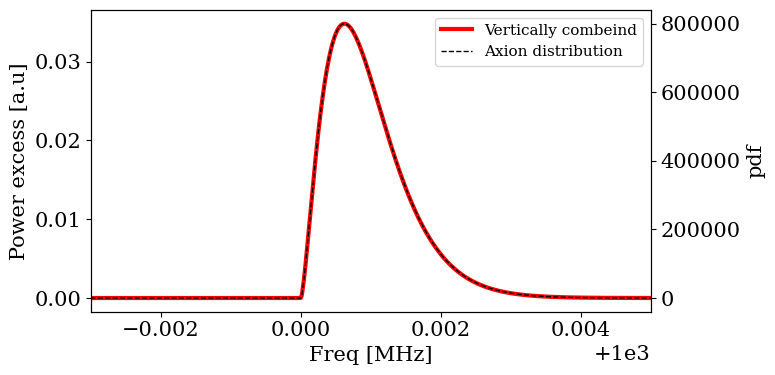

In [61]:
fig, ax = plt.subplots(figsize=(8, 4))
ax.plot( (freq_grand) / 1e6,sum_1,c ='r',label = 'Vertically combeind',lw = '3')
ax.set_xlim(left = (fa - 3*fa/Qa) / 1e6,right = (fa + 5*fa/Qa) / 1e6 )
axt = ax.twinx()
axt.plot(freq_grand/ 1e6,La(freq_grand/fa - 1,r_0* v_rms*c),c='k',ls= '--',lw = '1',label = 'Axion distribution')

handles_ax, labels_ax = ax.get_legend_handles_labels()
handles_axt, labels_axt = axt.get_legend_handles_labels()

ax.legend(handles_ax + handles_axt, labels_ax + labels_axt, fontsize=11, loc='upper right')
ax.set_xlabel('Freq [MHz]')
ax.set_ylabel('Power excess [a.u]')
axt.set_ylabel('pdf')
fig.tight_layout(h_pad=0.0, w_pad=0.0)
plt.show()

#### High Q factor

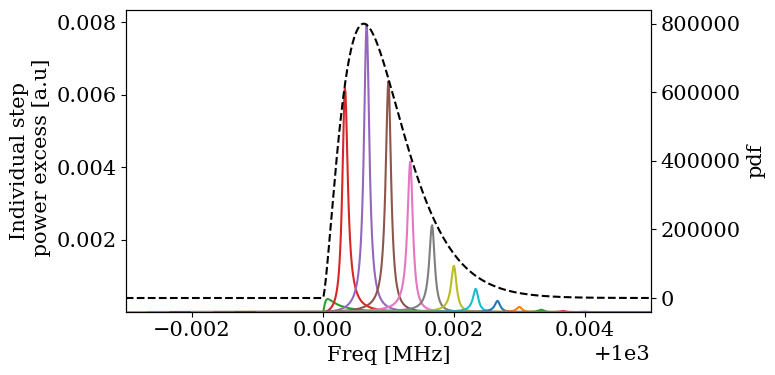

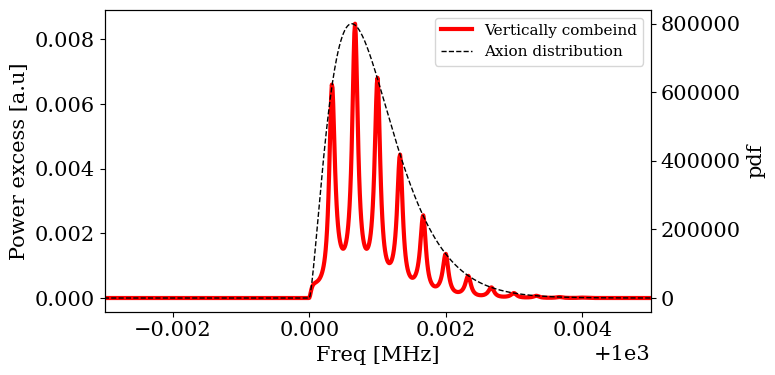

In [59]:
freqs_H = responses_H['freq']
powers_H = responses_H['response']
###
rbw = 10
ff = freqs_H[-1][-1]
fi = freqs_H[0][0]
n_grand = int((ff - fi ) / rbw + 1)
freq_grand = np.linspace(fi , ff , n_grand)
bin_grand = np.linspace(fi - rbw / 2, ff + rbw / 2, n_grand + 1)
sum_1, _, _ = binned_statistic(np.array(freqs_H).flatten(), np.array(powers_H).flatten() ,
                               statistic='sum', bins=bin_grand)
###
fig, ax = plt.subplots(figsize=(8, 4))
for idx,freq in enumerate(freqs_H):
    # if idx >13:
    #     continue
    ax.plot(freq/ 1e6,powers_H[idx])
    # print(len(freq))
# ax.set_yscale('log')
ax.set_ylim(bottom = 1e-5)
ax.set_xlim(left = (fa - 3*fa/Qa) / 1e6,right = (fa + 5*fa/Qa) / 1e6 )
axt = ax.twinx()
axt.plot(freq_grand/ 1e6,La(freq_grand/fa - 1,r_0* v_rms*c),c='k',ls= '--')
##
ax.set_xlabel('Freq [MHz]')
ax.set_ylabel('Individual step\n power excess [a.u]')
axt.set_ylabel('pdf')
fig.tight_layout(h_pad=0.0, w_pad=0.0)
##
plt.show()
###
fig, ax = plt.subplots(figsize=(8, 4))
ax.plot( (freq_grand) / 1e6,sum_1,c ='r',label = 'Vertically combeind',lw = '3')
ax.set_xlim(left = (fa - 3*fa/Qa) / 1e6,right = (fa + 5*fa/Qa) / 1e6 )
axt = ax.twinx()
axt.plot(freq_grand/ 1e6,La(freq_grand/fa - 1,r_0* v_rms*c),c='k',ls= '--',lw = '1',label = 'Axion distribution')

handles_ax, labels_ax = ax.get_legend_handles_labels()
handles_axt, labels_axt = axt.get_legend_handles_labels()

ax.legend(handles_ax + handles_axt, labels_ax + labels_axt, fontsize=11, loc='upper right')
ax.set_xlabel('Freq [MHz]')
ax.set_ylabel('Power excess [a.u]')
axt.set_ylabel('pdf')
fig.tight_layout(h_pad=0.0, w_pad=0.0)
plt.show()

### Generate an example spectrum

In [22]:
def Teff(f,Tp):
    w= 2*np.pi*f
    return hbar * w/kB * (1/ (np.exp(hbar * w/kB/Tp) - 1) + 1 / 2) 

In [23]:
def Bs(f, Q,rbw,params):
    a1, a2, a3 = params
    f0 = f[len(f) // 2]
    # print(f0/1e6, Q)
    delta = (f - f0) / (f0 / Q )
    # print(Tc)
    return (G * rbw * kB * Tc *
            (a1 + 8 * a2 * delta ** 2 + 4 * a3 * delta) /
            (1 + 4 * delta ** 2))

In [88]:
f_cent = 0.15e9
wa = 2*np.pi*f_cent
##
# T2H = 1e-2
QXe = 1e6 / 2
T2 = 2* QXe / wa
##
# print(QXe/Qa)
##

###
dfa = f_cent / Qa
dfs = f_cent / QXe
dfmu = np.max([dfa,dfs])
RBW = round_down_to_power_of_ten(dfs / 10)
dfs_0 = round_down_to_power_of_ten(dfs )
dfa_0 = round_down_to_power_of_ten(dfa )
dfmu_0 = round_down_to_power_of_ten(dfmu )
print('RBW:{} Hz &, BW spin:{} Hz, Axion:{} Hz, combine:{} Hz'.format(RBW,dfs,dfa,dfmu) )
print('RBW:{} Hz &, BW spin:{} Hz, Axion:{} Hz, combine:{} Hz'.format(RBW,dfs_0,dfa_0,dfmu_0) ) 
# RBW = dfs_0
# print(dfs,dfa_0,dfs_0,RBW)
# f_span = RBW * (n_span-1)
f_span = np.max([dfs_0,dfa_0]) * 20

n_span0 = int(f_span/dfs_0 + 1)
n_span_a = int(f_span/dfa_0 + 1)

# f = np.linspace(f_cent - f_span / 2, f_cent + f_span / 2, n_span)
f = f_cent + np.arange(-f_span / 2, f_span / 2 + RBW, RBW)
n_span = len(f)
# print(f_span,n_span0,n_span)
# print(len(f),len(f_0))
###
# f = np.linspace(f_cent - f_span / 2, f_cent + f_span / 2, n_span)

df = (f - f[n_span // 2]) / 1e3

###
N = 1e4
###
baseline = Bs(f, QXe,RBW,[1, 0.6, 0.3])
spectrum = baseline * (1 + 1 / np.sqrt(N) * np.random.randn(n_span))## Power spectrum
excesses = (spectrum - baseline) / baseline ## Normalized excess

## Expected power measured after digitizer at each frequency bin
# expected = G * (8*np.pi/3)**2 * (4 * beta/(1+beta)**2) *coeff * 2 * np.pi*f0 * mu0 * M0**2 * Beta**2 * V * Qm * Lc(f / f_cent) * Qs * rbw / f_cent
# expected0 = G * (g0**2 *mu0*hbarc*rho_a/(4*wa)) * (p * muXe * ns * v_rms * c)**2 *V * Qa*QXe / (QXe + Qa) *  La(f / f_cent - 1,r_0* v_rms*c) * RBW / f 
expected = G * (g0**2 *mu0*hbarc*rho_a/(4*wa)) * (p * muXe * ns * v_rms * c)**2 *V * Qa*QXe / (QXe + Qa) * expected_fit(f / f_cent - 1) * RBW
rescaled = excesses * (baseline / expected) ## rescaled spectrum

RBW:10 Hz &, BW spin:300.0 Hz, Axion:150.0 Hz, combine:300.0 Hz
RBW:10 Hz &, BW spin:100 Hz, Axion:100 Hz, combine:100 Hz


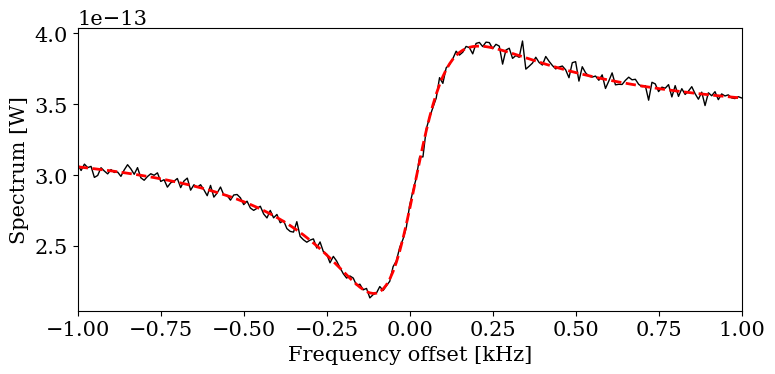

In [89]:
fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(df, spectrum, 'k', lw=1)
ax.plot(df, baseline, 'r--', lw=2)
ax.set_xlabel('Frequency offset [kHz]')
ax.set_ylabel('Spectrum [W]')
ax.set_xlim(left=df[0], right=df[-1])
# ax.set_xlim(-.63,.63)
# ax.set_ylim(1.4e-13,2.8e-13)
fig.tight_layout(h_pad=0.0, w_pad=0.0)
# plt.savefig('../figure/spectrum.pdf')
plt.show()

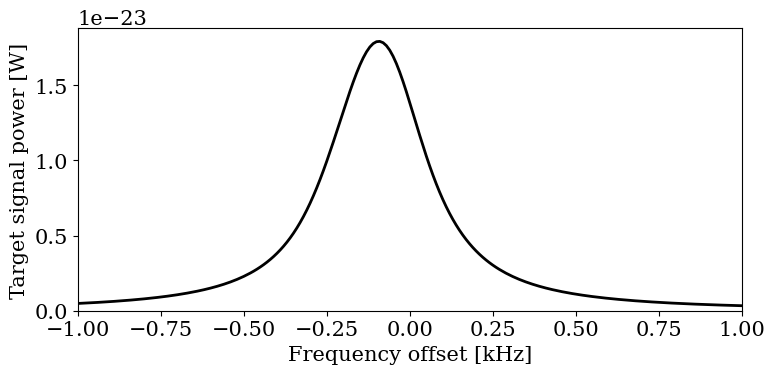

In [90]:
fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(df, expected, 'k', lw=2)
ax.set_xlabel('Frequency offset [kHz]')
ax.set_ylabel('Target signal power [W]')
ax.set_xlim(left=df[0], right=df[-1])
ax.set_ylim(bottom=0)
fig.tight_layout(h_pad=0.0, w_pad=0.0)
plt.show()

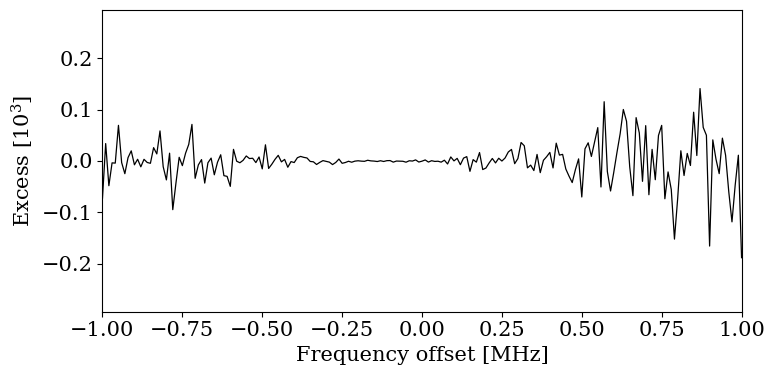

In [27]:
fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(df, rescaled / 1e3, 'k', lw=0.9)
ax.set_xlabel('Frequency offset [MHz]')
ax.set_ylabel('Excess [$10^{3}$]')
ax.set_xlim(left=df[0], right=df[-1])
ax.set_ylim(bottom=-7.5 * np.std(rescaled) / 1e3, top=7.5 * np.std(rescaled) / 1e3)
fig.tight_layout(h_pad=0.0, w_pad=0.0)
plt.show()

In [28]:

n_span = len(np.arange(-f_span / 2, f_span / 2 + RBW, RBW))
n_tune = 10_000
F = 3
f0 = 0.15e9
fi = f0 - n_tune/2* dfmu / F
ff = f0 + n_tune/2* dfmu / F
data_freq = np.zeros((n_tune, n_span))
data_spec = np.zeros((n_tune, n_span))
data_delta = np.zeros((n_tune, n_span))
data_sigma = np.zeros((n_tune, n_span))
for t, f_cent in enumerate(np.linspace(fi, ff, n_tune)):
    # freqs = np.linspace(f_cent - f_span / 2, f_cent + f_span / 2, n_span)
    # print(f_cent)
    freqs = f_cent + np.arange(-f_span / 2, f_span / 2 + RBW, RBW)
    # print(len(freqs),f_span,n_span)
    # print(QXe/1e6)
    baseline = Bs(freqs, QXe,RBW,[1, 0.6, 0.3])
    spectrum = baseline * (1 + 1 / np.sqrt(N) * np.random.randn(n_span))
    delta_p = (spectrum - baseline) / baseline

    sigma_p = (1 / np.sqrt(N) )* np.ones(n_span)
    # expected = G * (8*np.pi/3)**2 * (4 * beta/(1+beta)**2) *coeff * 2 * np.pi*f0 * mu0 * M0**2 * Beta**2 * V * Qm * Lc(freqs / f_cent) * Qs * rbw / f_cent
    expected = G * (g0**2 *mu0*hbarc*rho_a/(4*wa)) * (p * muXe * ns * v_rms * c)**2 *V * Qa*QXe / (QXe + Qa) * expected_fit((freqs - f_cent + f0) / f0 - 1) * RBW 
    # ###
    ###
    delta_r = delta_p * (baseline / expected)
    sigma_r = sigma_p * (baseline / expected)
    ###
    # plt.plot(freqs, delta_r)
    # # plt.plot(expected_fit(f / f0 - 1) )
    # plt.ylim(-2000,2000)
    # plt.show()
    # assert 0
    # ###

    data_freq[t] = freqs
    data_spec[t] = spectrum
    data_delta[t] = delta_r
    data_sigma[t] = sigma_r

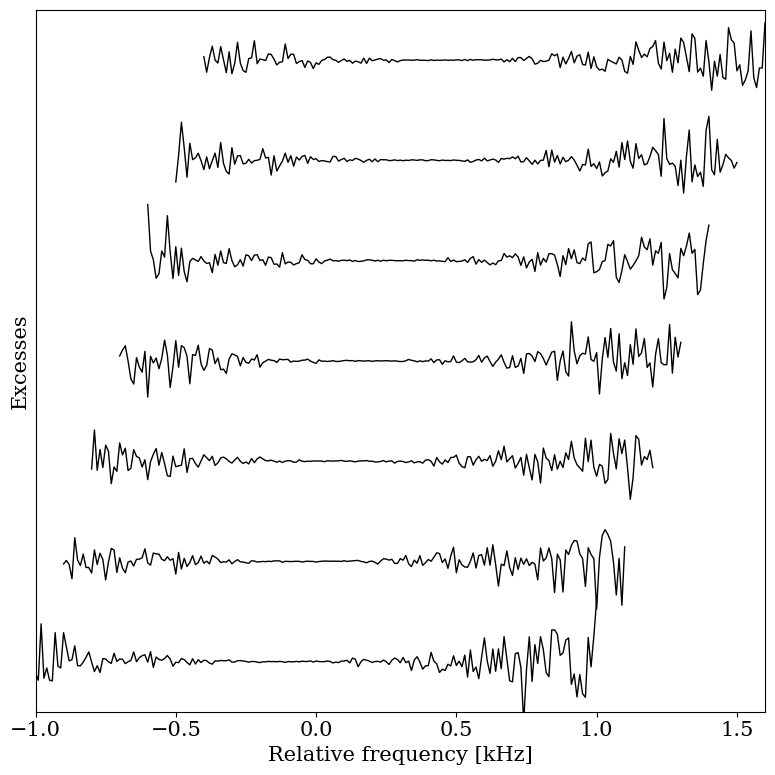

In [29]:
fig, ax = plt.subplots(figsize=(8, 8))
n_example = 7
offset_example = 10 * np.std(data_delta[0:n_example].flatten())
for t in range(n_example):
    ax.plot((data_freq[t] - fi) / 1e3, data_delta[t] + offset_example * (t - (n_example - 1) / 2), 'k', lw=1)
ax.set_xlabel('Relative frequency [kHz]')
ax.set_ylabel('Excesses')
ax.set_xlim(left=(data_freq[0][0] - fi) / 1e3, right=(data_freq[n_example - 1][-1] - fi) / 1e3)
ax.set_ylim(bottom=-offset_example * ((n_example - 1) / 2 + 0.5), top=offset_example * ((n_example - 1) / 2 + 0.5))
ax.set_yticks([])
fig.tight_layout(h_pad=0.0, w_pad=0.0)
# plt.savefig('../figure/rescaled_excesses.pdf')
plt.show()

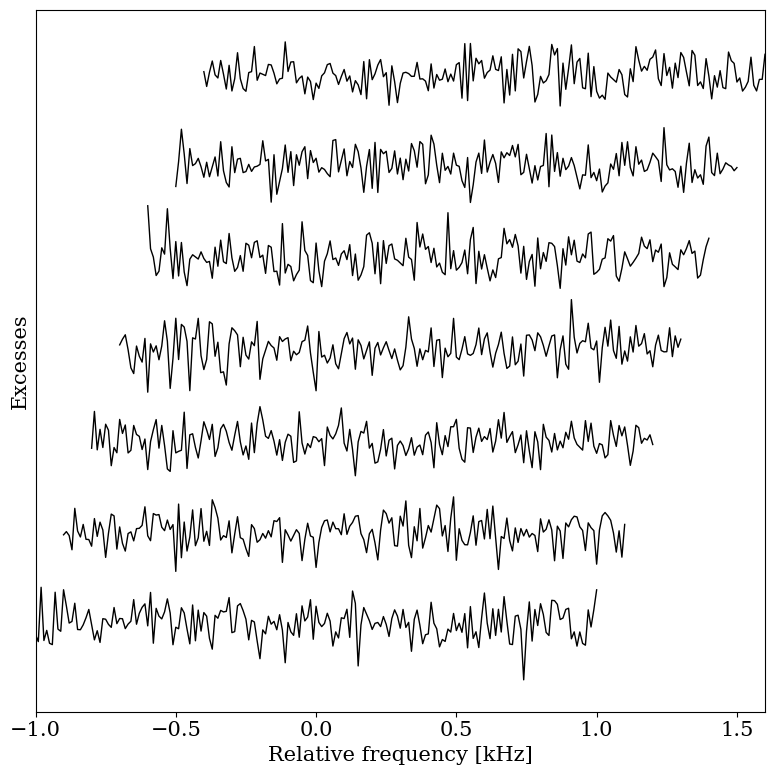

In [30]:
fig, ax = plt.subplots(figsize=(8, 8))
n_example = 7
offset_example = 10 * np.std(data_delta[0:n_example].flatten())
for t in range(n_example):
    ax.plot((data_freq[t] - fi) / 1e3, data_delta[t] / data_sigma[t] + 6 * (t - (n_example - 1) / 2), 'k', lw=1)
ax.set_xlabel('Relative frequency [kHz]')
ax.set_ylabel('Excesses')
ax.set_xlim(left=(data_freq[0][0] - fi) / 1e3, right=(data_freq[n_example - 1][-1] - fi) / 1e3)
# ax.set_ylim(bottom=-offset_example * ((n_example - 1) / 2 + 0.5), top=offset_example * ((n_example - 1) / 2 + 0.5))
ax.set_yticks([])
fig.tight_layout(h_pad=0.0, w_pad=0.0)
# plt.savefig('../figure/rescaled_excesses.pdf')
plt.show()

### Vertical combination

In [31]:
f_step = f_span / (n_span - 1) # frequency step in data points [Hz]
n_grand = int((ff - fi + f_span) / f_step + 1)
freq_grand = np.linspace(fi -f_span/2, ff + f_span/2 , n_grand)
bin_grand = np.linspace(fi - f_span / 2 - f_step / 2, ff + f_span / 2 + f_step / 2, n_grand + 1)
sum_1, _, _ = binned_statistic(data_freq.flatten(), data_delta.flatten() * np.power(data_sigma.flatten(), -2),
                               statistic='sum', bins=bin_grand)
sum_2, _, _ = binned_statistic(data_freq.flatten(), np.power(data_sigma.flatten(), -2),
                               statistic='sum', bins=bin_grand)
delta_v = sum_1 / sum_2
sigma_v = 1 / np.sqrt(sum_2)

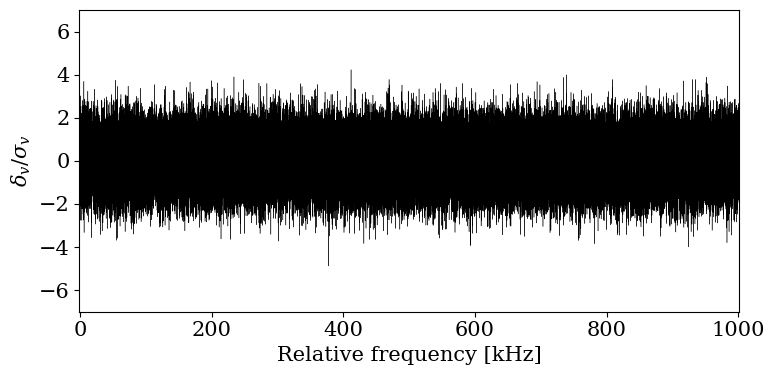

In [32]:
threshold = 3.71845
norm_v = delta_v / sigma_v
cand_v = norm_v >= threshold

fig, ax = plt.subplots(figsize=(8, 4))
ax.plot((freq_grand - fi) / 1e3, norm_v, 'k', lw=0.3)
ax.set_xlabel('Relative frequency [kHz]')
ax.set_ylabel('$\\delta_{{v}} / \\sigma_{{v}}$')
ax.set_xlim(left=(freq_grand[0] - fi) / 1e3, right=(freq_grand[-1] - fi) / 1e3)
ax.set_ylim(bottom=-7, top=7)
fig.tight_layout(h_pad=0.0, w_pad=0.0)
# plt.savefig('../figure/vertical_combined.pdf')
plt.show()

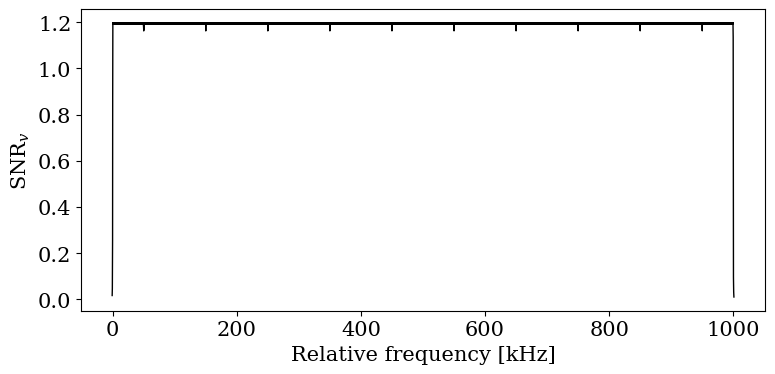

In [33]:
fig, ax = plt.subplots(figsize=(8, 4))
ax.plot((freq_grand - fi) / 1e3, 1 / sigma_v, 'k', lw=1)
ax.set_xlabel('Relative frequency [kHz]')
ax.set_ylabel('SNR$_{{v}}$')
# ax.set_xlim(left=(freq_grand[0] - fi) / 1e3, right=(freq_grand[-1] - fi) / 1e3)
# ax.set_xlim(200,220)
# ax.set_ylim(bottom=1)
fig.tight_layout(h_pad=0.0, w_pad=0.0)
# plt.savefig('../figure/vertical_combined_SNR.pdf')
plt.show()

In [34]:
Scan_width = (freq_grand[-1]-fi)/1e6
num_scan = 1e6 * Scan_width / (dfmu / F)
total_time = num_scan * N / RBW / 3600/24
##
v_sens = np.mean(1 / sigma_v[len(sigma_v)//3:2*len(sigma_v)//3])
# print(v_sens)
print('vertical: Scan range {:.2f} MHz, DAQ time: {:.2f} days, {:.1e} Avg, Sensitivity: {:.2e} [1/GeV]'.format((freq_grand[-1]-fi)/1e6
                                                                                                         , total_time, N,np.sqrt(5 / v_sens) *g0 *1e9))


vertical: Scan range 1.00 MHz, DAQ time: 115.86 days, 1.0e+04 Avg, Sensitivity: 2.25e-04 [1/GeV]


### Horizontal combination

In [35]:
f_step, RBW

(np.float64(10.0), 10)

In [36]:
n_horizontal = 1001
def horizontal_combine(f):
    freqs_edge = np.linspace(f - f_step / 2, f + (n_horizontal - 0.5) * f_step, n_horizontal + 1)
    freqs = (freqs_edge[1:] + freqs_edge[:-1]) / 2
    neighbor = (f <= freq_grand) & (freq_grand <= f + (n_horizontal - 1) * f_step)
    length = int(np.sum(neighbor))
    distri = La(freqs_edge / f - 1, r_0)
    weight = (distri[1:] + distri[:-1])[:length] / 2 * (freqs[:length] / f) / Qs
    sum_3 = np.sum(weight * delta_v[neighbor] * np.power(sigma_v[neighbor], -2))
    sum_4 = np.sum(np.power(weight, 2) * np.power(sigma_v[neighbor], -2))

    return sum_3 / sum_4, 1 / np.sqrt(sum_4)

In [37]:
horizontal_combine(freq_grand[len(freq_grand)//2])

(np.float64(-0.41443286743827457), np.float64(0.19516155560342388))

In [38]:
combined = Parallel(n_jobs=4)(delayed(horizontal_combine)(f_axion) for f_axion in freq_grand)
delta_h = np.array(combined)[:, 0]
sigma_h = np.array(combined)[:, 1]

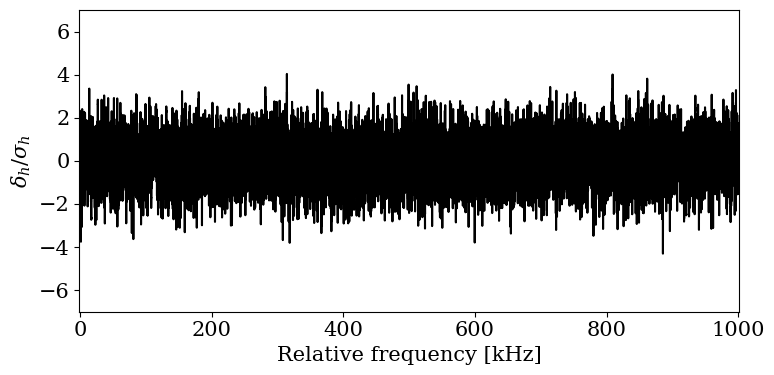

In [39]:
norm_h = delta_h / sigma_h

fig, ax = plt.subplots(figsize=(8, 4))
ax.plot((freq_grand - fi) / 1e3, norm_h, 'k')
ax.set_xlabel('Relative frequency [kHz]')
ax.set_ylabel('$\\delta_{{h}} / \\sigma_{{h}}$')
ax.set_xlim(left=(freq_grand[0] - fi) / 1e3, right=(freq_grand[-1] - fi) / 1e3)
ax.set_ylim(bottom=-7, top=7)
fig.tight_layout(h_pad=0.0, w_pad=0.0)
# plt.savefig('../figure/horizontal_combined.pdf')
plt.show()

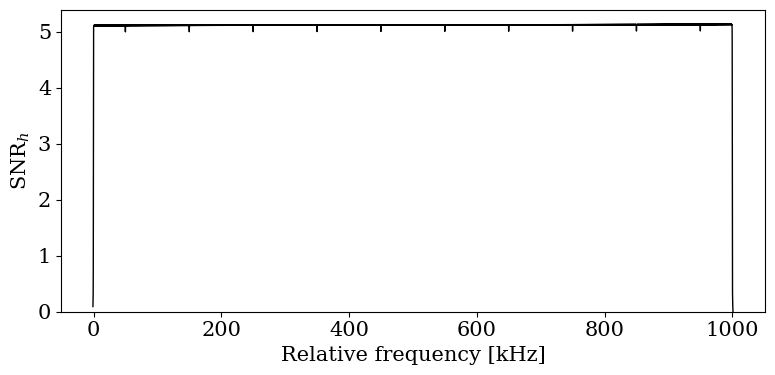

In [40]:
fig, ax = plt.subplots(figsize=(8, 4))
ax.plot((freq_grand - fi) / 1e3, 1 / sigma_h, 'k', lw=1)
ax.set_xlabel('Relative frequency [kHz]')
ax.set_ylabel('SNR$_{{h}}$')
# ax.set_xlim(left=(freq_grand[0] - fi) / 1e3, right=(freq_grand[-1] - fi) / 1e3)
ax.set_ylim(bottom=0)
fig.tight_layout(h_pad=0.0, w_pad=0.0)
# plt.savefig('../figure/vertical_combined_SNR.pdf')
plt.show()
###
# fig, ax = plt.subplots(figsize=(8, 4))
# ax.plot((freq_grand - fi) / 1e3, 1 / sigma_h, 'k', lw=1)
# ax.set_xlabel('Relative frequency [kHz]')
# ax.set_ylabel('SNR$_{{h}}$')
# ax.set_xlim(left=140, right=150)
# ax.set_ylim(bottom=5.0,top = 5.1)
# fig.tight_layout(h_pad=0.0, w_pad=0.0)
# # plt.savefig('../figure/vertical_combined_SNR.pdf')
# plt.show()

In [41]:
h_sens = np.mean(1 / sigma_h[len(sigma_h)//3:2*len(sigma_h)//3])
# print(h_sens)
print('Horizontal: Scan range {:.2f} MHz, DAQ time: {:.2f} days, {:.1e} Avg, Sensitivity: {:.2e} [1/GeV]'.format((freq_grand[-1]-fi)/1e6
                                                                                                         , total_time
                                                                                                                 , N,np.sqrt(5 / h_sens) *g0 *1e9))

Horizontal: Scan range 1.00 MHz, DAQ time: 115.86 days, 1.0e+04 Avg, Sensitivity: 1.09e-04 [1/GeV]


In [2]:
100e6*2*1e-6/3

66.66666666666667

In [3]:
1e6/70

14285.714285714286

In [4]:
1e4/100

100.0

In [5]:
(1e6)**0.25

31.622776601683793